# MCT4052 Workshop 3a: K-Nearest Neighbors Classifier

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to train and use a K-Nearest Neighbors (KNN) classifier. The dataset, features extraction and classification task are identical to the example in Workshop2b, but we replace the Gaussian naïve Bayesian calssifier with a more powerful and flexible [K-Nearest Neighbosr classifier (KNN)](https://scikit-learn.org/stable/modules/neighbors.html) classifier. 

KNN allows to tune several parameters to improve the performances of the classifier. For more details, refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Mind that KNN can also be used as an unsupervised ML method.


In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
#ms.use("seaborn-v0_8") 
import IPython.display as Ipd
import os
import sklearn

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
sr = 22050

#Instead of writing the code to extract the features we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#All features are from librosa and are all scalar (we take the mean over multiple blocks computed across the duration, which differs for each file).
#The function returns a list containing the mean of the features given an filename, and the sampling rate at which we are resampling the file
#Mind that these features may not be the best to perform the classification task (it's just an example!)
def extract_features(filename, sr=sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = [
        np.mean(librosa.feature.zero_crossing_rate(y=signal)),
        np.mean(librosa.feature.spectral_centroid(y=signal)),
        np.mean(librosa.feature.spectral_flatness(y=signal))
    ]
    
    return output


#creating an array of zeros of the proper size where we will store computed features and lables
filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),3)) #we compute the average of 3 features in the above code
labels = np.zeros((len(filenames))) #we store the labels as integers
classes = ['kick','snare','cymbal','clap'] #list of text labels to conver numberical labels to text labels

for i in range(len(filenames)):
    #print('processing',filenames[i])
    features[i,:] = extract_features('./data/examples2/'+filenames[i], sr=sr)
    if filenames[i].find('kick') != -1:
        labels[i] = 0
    elif filenames[i].find('snare') != -1:
        labels[i] = 1
    elif filenames[i].find('cymbal') != -1:
        labels[i] = 2
    elif filenames[i].find('clap') != -1:
        labels[i] = 3

print('Done!')

Done!


In [3]:
#this step converts the labels from a numpy array to 
#a Pandas series, which allows backtracing misclassified examples
#scikitlearn can handle features or labels also as Pandas formats
labels = pd.Series(labels)

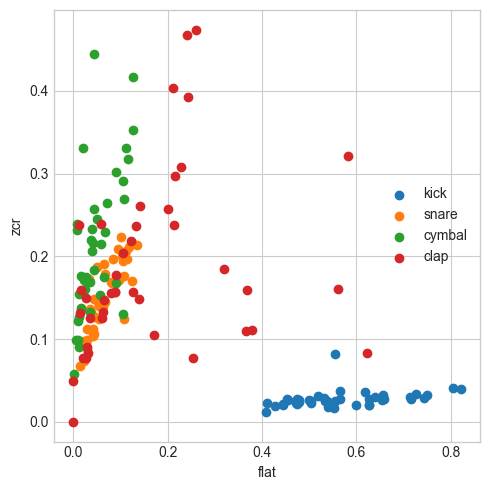

In [4]:
#Plotting the features in a 2D scatter plot
#we can plot up to 2 features (or you can attempt a 3D plot) 
#we also include an histrogram (different view of the same data)

#create a dictionary of features so that we can toggle between indexes and labels for each individual feature
feature_dict = {'zcr':0,
                'cent':1,
                'flat':2}

select1 = 'flat'
select2 = 'zcr'

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    for lab_val, lab_name in zip(range(0,50),classes):
        plt.scatter(features[labels==lab_val, feature_dict[select1]],
                    features[labels==lab_val, feature_dict[select2]],
                    label=lab_name)
    plt.xlabel(select1)
    plt.ylabel(select2)
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.3, random_state=14)

In [6]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

### Creating, training and testing the KNN Classifier, computing classification performance metrics

The number of neigbors to consider (k) is an important settings in KNN. These can be changed/tuned to significantly improve perforance.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

#Creating an instance of a KNN classifier
#and setting it to classify according to 3 nearest neighbor
model_KNN = KNeighborsClassifier(n_neighbors=3)

sklearn.neighbors
#training the model
model_KNN.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict =  model_KNN.predict(feat_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 13 out of 51
Accuracy: 0.7450980392156863


In [8]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        17
         1.0       0.69      0.79      0.73        14
         2.0       0.54      0.64      0.58        11
         3.0       0.75      0.33      0.46         9

    accuracy                           0.75        51
   macro avg       0.73      0.69      0.69        51
weighted avg       0.75      0.75      0.73        51

[[17  0  0  0]
 [ 0 11  3  0]
 [ 0  3  7  1]
 [ 1  2  3  3]]


In [9]:
#displaying names of misclassified files
results = lab_test == lab_predict
for index, value in enumerate(results):
    if value == False:
        print(filenames[index], 'misclassified as', classes[int(lab_predict[index])])


snare_01.wav misclassified as snare
snare_29.wav misclassified as kick
snare_13.wav misclassified as cymbal
snare_05.wav misclassified as cymbal
snare_04.wav misclassified as cymbal
cymbal29.wav misclassified as snare
cymbal01.wav misclassified as cymbal
cymbal15.wav misclassified as snare
cymbal00.wav misclassified as clap
clap25.wav misclassified as snare
kick_04.wav misclassified as cymbal
clap27.wav misclassified as snare
clap26.wav misclassified as cymbal


### Follou-up activity

1. change the k-NN parameters, such as the number of neighbors, the algorithm, the metric, the weights, etc.
For more details, refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).
2. Try with one of your own dataset and compare the performances with other classifiers included in Workshop 3.
3. (advanced, optional) Implement your own KNN classifier.